In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tikzplotlib

run_id = 39
folder_path = f'../data/results/run_{run_id}/'

In [3]:
results_deviance = pd.read_csv(folder_path + 'results_deviance.csv', index_col=0)
print((results_deviance*100).round(3))

                  train    test
intercept        25.207  25.507
glm              24.157  24.422
local-glm-boost  23.707  24.008


In [19]:
# print (results_deviance*100).round(3) as a latex table
# But with capitalized first letter
# and train replaced with Training
# and local-glm-boost as LocalGLMBoost
# and glm as GLM

new_table = (results_deviance*100).copy()
new_table.index = [index.capitalize() for index in new_table.index]
new_table.columns = [column.capitalize() for column in new_table.columns]
new_table.rename(columns={'Train':'Training'}, inplace=True)
new_table.rename(columns={'Local-glm-boost':'LocalGLMBoost'}, inplace=True)
new_table.rename(columns={'Glm':'GLM'}, inplace=True)
print(new_table.to_latex(float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
{} &  Training &   Test \\
\midrule
Intercept       &    25.207 & 25.507 \\
Glm             &    24.157 & 24.422 \\
Local-glm-boost &    23.707 & 24.008 \\
\bottomrule
\end{tabular}



In [110]:
n_estimators = pd.read_csv(folder_path + 'n_estimators.csv', index_col=0)['n_estimators']
# Make a bar plot with high values on top
features = n_estimators.index
cont_features = ['VehPower', 'VehAge', 'Density', 'DrivAge', 'BonusMalus', 'Area']
veh_features = [feature for feature in features if feature.startswith('VehBrand')]
region_features = [feature for feature in features if feature.startswith('Region')]
row = ' & '.join([str(n_estimators.loc[feature]) for feature in cont_features])

row += ' & (' + str(n_estimators[veh_features].min()) + ', ' + str(n_estimators[veh_features].max()) + ')'
row += ' & (' + str(n_estimators[region_features].min()) + ', ' + str(n_estimators[region_features].max()) + ')'
row += ' \\\\'
print(row)

145 & 63 & 30 & 155 & 65 & 92 & (0, 145) & (0, 127) \\


In [111]:
beta0 = pd.read_csv(folder_path + 'beta_estimates.csv', index_col=0)['beta0']
row = ' & '.join([str(beta0.loc[feature].round(2)) for feature in cont_features])
row += ' & (' + str(beta0[veh_features].min().round(2)) + ', ' + str(beta0[veh_features].max().round(2)) + ')'
row += ' & (' + str(beta0[region_features].min().round(2)) + ', ' + str(beta0[region_features].max().round(2)) + ')'
row += ' \\\\'
print(row)

0.52 & -1.77 & -0.04 & 0.61 & 6.09 & 0.44 & (-0.7, -0.22) & (-0.46, 0.07) \\


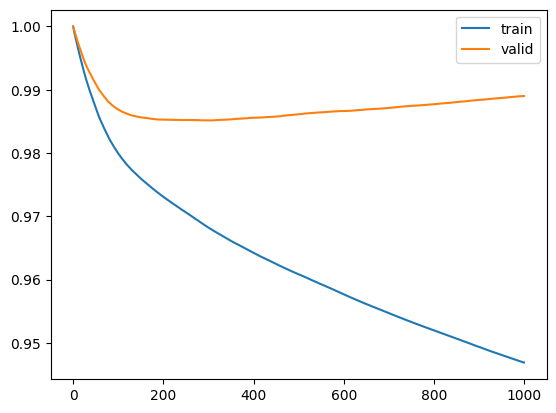

In [6]:
loss_train = pd.read_csv(folder_path + 'loss_tuning_train.csv', index_col=0)
# Extract the last column
loss_train = loss_train.iloc[:, -1]
loss_valid = pd.read_csv(folder_path + 'loss_tuning_valid.csv', index_col=0)
# Extract the last column
loss_valid = loss_valid.iloc[:, -1]

(loss_train/loss_train.iloc[0]).plot(label='train')
(loss_valid/loss_valid.iloc[0]).plot(label='valid')
plt.legend();


In [7]:
# Checkout the feature importances
feature_importances = pd.read_csv(folder_path + 'feature_importances.csv', index_col=0)
# Sum up categorical features
categorical_features = ['VehBrand','Region']
feature_importances_new = feature_importances.copy()
# Sum columns with categorical feature prefixes
for categorical_feature in categorical_features:
    features_with_this_category = [column for column in feature_importances.columns if column.startswith(categorical_feature)]
    feature_importances_new[categorical_feature] = feature_importances[features_with_this_category].sum(axis=1)
    feature_importances_new.drop(features_with_this_category, axis=1, inplace=True)


In [8]:
non_boosted_features = [feature for feature in n_estimators.index if n_estimators.loc[feature, 'n_estimators'] == 0]
# drop these from the new feature importances
feature_importances_new.drop(non_boosted_features, axis=0, inplace=True)


<AxesSubplot:>

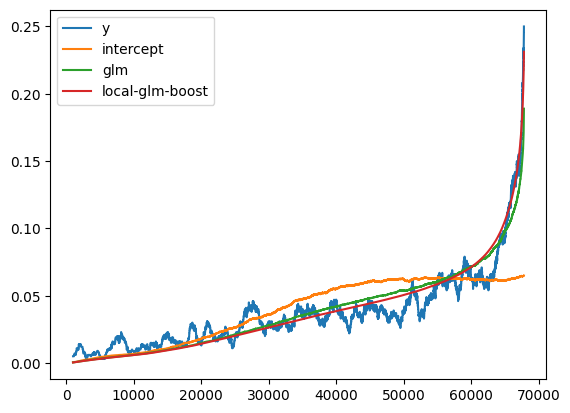

In [29]:
predictions = pd.read_csv(folder_path + 'predictions.csv', index_col=0)
mu_hat = predictions[['intercept','glm','local-glm-boost']].mul(predictions['w'],axis=0)
mu_hat['y'] = predictions['y']

n = len(mu_hat)
window_size = 1000 # n//100
prediction_results = mu_hat.sort_values('local-glm-boost').reset_index(drop=True).rolling(window_size).mean()[['y','intercept','glm','local-glm-boost']].dropna()
prediction_results.plot()

<Figure size 1200x500 with 0 Axes>

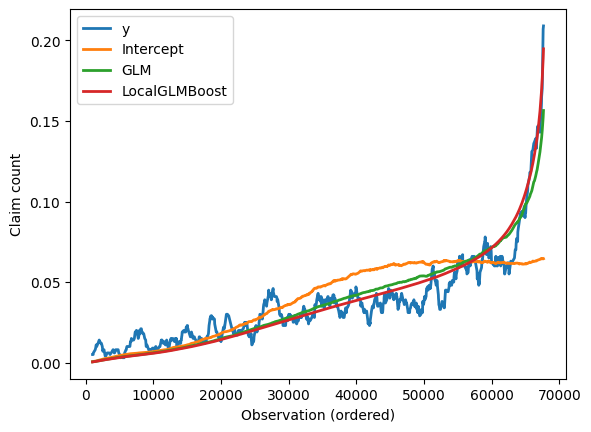

In [39]:
# Sample the data
sampled_predictions = prediction_results.sample(1000)
sampled_predictions.sort_values('local-glm-boost', inplace=True)

plt.figure(figsize=(12,5))
# Replace the column names with the names of the models
sampled_predictions.columns = ['y','Intercept','GLM','LocalGLMBoost']
# Plot the data with thicker lines
sampled_predictions.plot(linewidth=2);
# Add x-axis label "Observation (ordered)"
plt.xlabel('Observation (ordered)');
# Change the y-axis label to "Claim count (rolling average)"
plt.ylabel('Claim count');
# Save as tikz
tikzplotlib.save(folder_path + 'real_data_predictions.tex')
